# <font color='#1a5276'> <b> <center> Gradient Descent with Momentum </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Visualization in a polynomial function](#3) <br>
    3.1. [Helper Functions](#3.1) <br>
    3.2. [Model](#3.2) <br>
    3.3. [Saddle points](#3.3) <br>
    3.4. [Local minima](#3.4) <br>
4. [Neural Networks with Momentum](#4) <br>
    4.1. [Helper Functions](#4.1) <br>
    4.2. [Data](#4.2) <br>
    4.3. [Model, criterion and training function](#4.3) <br>
    4.4. [Training](#4.4) <br>
    4.5. [Comparisson of results](#4.5) <br>
5. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In this notebook, we will explore the role of momentum in optimization and its impact on improving convergence:

- Part 1: Visualization on a Polynomial Function
    - We'll examine how momentum helps navigate challenging optimization landscapes, such as saddle points and local minima, using a polynomial function. This will provide insights into the dynamics of optimization with and without momentum.

- Part 2: Application to a Neural Network
    - We'll implement and compare momentum in the context of training a simple neural network, highlighting its effect on convergence speed and model performance.


<a name="2"></a>
## <font color='blue'> <b> 2. Setup </b> </font>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from matplotlib.colors import ListedColormap

In [3]:
torch.manual_seed(0)

<a name="3"></a>
## <font color='blue'> <b> 3. Visualization in a Polynomial Function </b> </font>

<a name="3.1"></a>
### <font color='#1f618d'> <b> 3.1. Helper Functions </b> </font>

In [4]:
def plot_cubic(w, optimizer, cubic_fn):
    """
    Plot the optimization process for a cubic function using a given optimizer.

    Args:
        w (torch.nn.Module): A PyTorch model representing the parameter to be optimized.
        optimizer (torch.optim.Optimizer): A PyTorch optimizer used to update the parameter.
        cubic_fn (callable): The cubic-like loss function to minimize.

    The function visualizes the cubic function's loss landscape and overlays the optimization trajectory
    of the parameter `w` as it is updated by the optimizer over multiple epochs.
    """
    LOSS = []  # List to store the loss values for the entire range of `w`
    
    # Generate a range of parameter values from -4 to 4 with a step of 0.1
    W = torch.arange(-4, 4, 0.1)
    
    # Compute the loss for each value in W
    for w.state_dict()['linear.weight'][0] in W:
        LOSS.append(cubic_fn(w(torch.tensor([[1.0]]))).item())
    
    # Reset the parameter value to 4.0 before optimization
    w.state_dict()['linear.weight'][0] = 4.0
    n_epochs = 10  # Number of optimization steps (epochs)
    parameter = []  # List to store parameter values during optimization
    loss_list = []  # List to store loss values during optimization

    # Perform optimization for n_epochs
    for n in range(n_epochs):
        optimizer.zero_grad()  # Clear the gradients
        loss = cubic_fn(w(torch.tensor([[1.0]])))  # Compute the current loss
        loss_list.append(loss.item())  # Store the loss
        parameter.append(w.state_dict()['linear.weight'][0].detach().item())  # Store the parameter value
        loss.backward()  # Compute gradients
        optimizer.step()  # Update the parameter using the optimizer

    # Plot the optimization trajectory and the cubic function
    plt.plot(parameter, loss_list, 'ro', label='parameter values')  # Trajectory of parameter updates
    plt.plot(W.detach().numpy(), LOSS, label='objective function')  # Loss landscape
    plt.xlabel('w')  # Label for x-axis
    plt.ylabel('l(w)')  # Label for y-axis
    plt.legend()  # Add a legend



    
    
# Plot the optimization process for a fourth-order polynomial 
def plot_fourth_order(w, optimizer, fourth_order, std=0, color='r', paramlabel='parameter values', objfun=True):
    """
    Plot the optimization process for a fourth-order polynomial function using a given optimizer.

    Args:
        w (torch.nn.Module): A PyTorch model representing the parameter to be optimized.
        optimizer (torch.optim.Optimizer): A PyTorch optimizer used to update the parameter.
        fourth_order (callable): The fourth-order polynomial function to be optimized.
        std (float): Standard deviation of noise added to the loss (default is 0, no noise).
        color (str): Color for the parameter trajectory plot (default is 'r' for red).
        paramlabel (str): Label for the parameter trajectory in the legend (default is 'parameter values').
        objfun (bool): Whether to plot the objective function (default is True).

    This function visualizes the fourth-order polynomial loss landscape and overlays the optimization trajectory
    of the parameter `w` as it is updated by the optimizer over multiple epochs. Optionally, noise can be added to 
    simulate stochastic optimization.
    """
    # Generate a range of parameter values from -4 to 6 with a step of 0.1
    W = torch.arange(-4, 6, 0.1)
    LOSS = []  # List to store the loss values for the entire range of `W`

    # Compute the loss for each value in W
    for w.state_dict()['linear.weight'][0] in W:
        LOSS.append(fourth_order(w(torch.tensor([[1.0]]))).item())
    
    # Reset the parameter value to 6 before optimization
    w.state_dict()['linear.weight'][0] = 6
    n_epochs = 100  # Number of optimization steps (epochs)
    parameter = []  # List to store parameter values during optimization
    loss_list = []  # List to store loss values during optimization

    # Perform optimization for n_epochs
    for n in range(n_epochs):
        optimizer.zero_grad()  # Clear the gradients
        # Compute the current loss with optional noise
        loss = fourth_order(w(torch.tensor([[1.0]]))) + std * torch.randn(1, 1)
        loss_list.append(loss.item())  # Store the scalar loss value
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())  # Store the parameter value
        loss.backward()  # Compute gradients
        optimizer.step()  # Update the parameter using the optimizer

    # Plot the optimization trajectory and optionally the fourth-order objective function
    if objfun:
        plt.plot(W.detach().numpy(), LOSS, label='objective function')  # Loss landscape
    plt.plot(parameter, loss_list, 'ro', label=paramlabel, color=color)  # Trajectory of parameter updates
    plt.xlabel('w')  # Label for x-axis
    plt.ylabel('l(w)')  # Label for y-axis
    plt.legend()  # Add a legend

    

<a name="3.2"></a>
### <font color='#1f618d'> <b> 3.2. Model </b> </font>

We will create a simple model.

In [5]:
# Create a linear model
class SimpleModel(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [6]:
# Create a model object
model = SimpleModel(1, 1)

<a name="3.3"></a>
### <font color='#1f618d'> <b> 3.3. Saddle points </b> </font>

### Without momentum

In [7]:
# Create a optimizer without momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)

In [8]:
# Define a function to output a cubic, note it has a saddle point in 0
def cubic(yhat):
    out = yhat ** 3
    return out

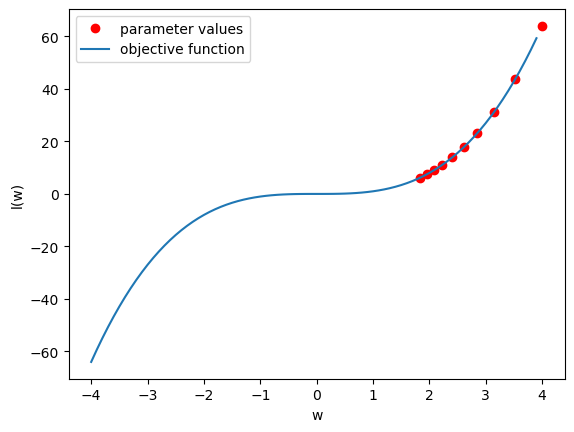

In [9]:
# Execute a few iterations of the gradient descent and plot
plot_cubic(model, optimizer, cubic)

We see that the parameter values get stuck at the saddle point.

### With momentum

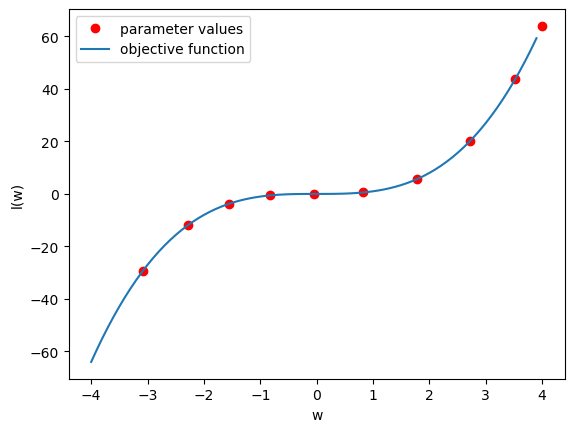

In [10]:
# Create a model object
model = SimpleModel(1, 1)

# Create a optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# training and plot
plot_cubic(model, optimizer, cubic)

We observe that the parameter values no longer get trapped at the saddle point.

<a name="3.4"></a>
### <font color='#1f618d'> <b> 3.4. Local minima </b> </font>

In [11]:
# Create a function to calculate the fourth order polynomial, note it has local minima in 4
# and a global minima in -2
def fourth_order(yhat): 
    out = torch.mean(2 * (yhat ** 4) - 9 * (yhat ** 3) - 21 * (yhat ** 2) + 88 * yhat + 48)
    return out

### Without momentum

/tmp/ipykernel_9144/1508774872.py:93: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(parameter, loss_list, 'ro', label=paramlabel, color=color)  # Trajectory of parameter updates


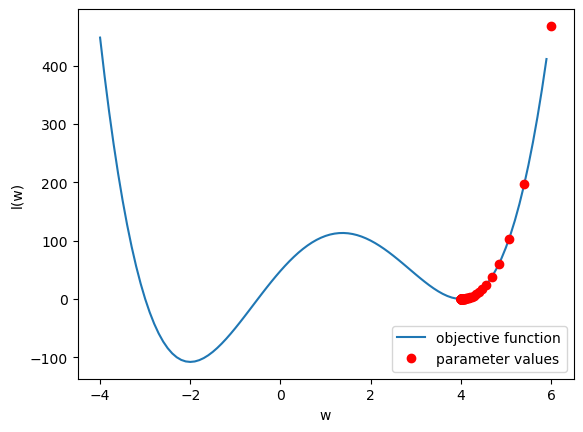

In [12]:
# Create a model object
model = SimpleModel(1, 1)

# create an optimizer without momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# training and plot
plot_fourth_order(model, optimizer, fourth_order)

We can see that it gets stuck in a local minimum.

### With momentum

/tmp/ipykernel_9144/1508774872.py:93: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(parameter, loss_list, 'ro', label=paramlabel, color=color)  # Trajectory of parameter updates


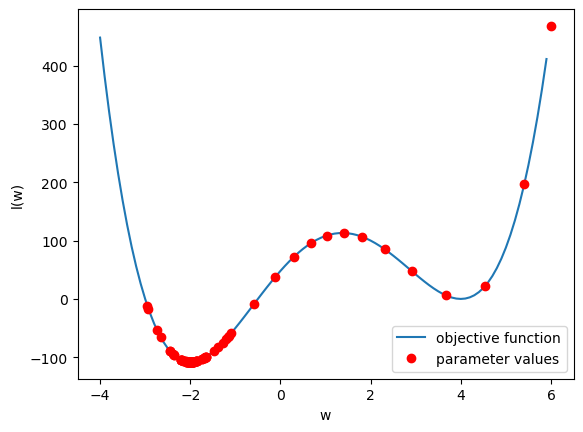

In [13]:
# Create a model object
model = SimpleModel(1, 1)

# create an optimizer without momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# training and plot
plot_fourth_order(model, optimizer, fourth_order)

We can see that now we reach the global minimum.

<a name="4"></a>
## <font color='blue'> <b> 4. Neural Netwoks with Momentum </b> </font>

<a name="4.1"></a>
### <font color='#1f618d'> <b> 4.1. Helper Functions </b> </font>

In [91]:
def plot_decision_regions_3class(model, data_set, title):
    """
    Plot the decision regions for a 3-class classification model.

    This function generates a plot that visualizes the decision boundaries of a classification model 
    for a 2D dataset. The decision regions are color-coded according to the predicted class labels, 
    and the data points are also plotted with different colors for each class.

    Args:
        model (torch.nn.Module): A PyTorch model used for classification.
        data_set (torch.utils.data.Dataset): A dataset object containing the input data (X) 
                                              and corresponding labels (y).
    """
    
    # Create a new figure to avoid overlapping plots
    plt.figure()
    
    # Define colormap for plotting decision regions (light colors for regions, bold colors for points)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])  # Light color regions
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])   # Bold color points

    # Convert the input data and labels to numpy arrays
    X = data_set.x.numpy()
    y = data_set.y.numpy()

    # Set step size for mesh grid
    h = .02

    # Define the limits for the plot axes based on the input data
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create meshgrid for plotting decision regions
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Flatten the meshgrid and convert it to a tensor for input to the model
    XX = torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    # Perform model prediction and get the predicted class labels
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)

    # Plot decision regions (color-coding the regions based on predicted classes)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)

    # Plot the data points for each class with different colors
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label='y=0')  # Class 0 in red
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label='y=1')  # Class 1 in green
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label='y=2')   # Class 2 in blue

    # Set title and display the legend
    plt.title(f"Decision Region, {title}")
    plt.legend()
    plt.show()



In [23]:
# Calculate accuracy
def accuracy(model, dataset):
    _, yhat = torch.max(model(dataset.x), 1)
    return (yhat == dataset.y).numpy().mean()

<a name="4.2"></a>
### <font color='#1f618d'> <b> 4.2. Data </b> </font>

In [16]:
class Data(Dataset):
    """
    A custom dataset class that generates and stores 2D data points for a classification problem.
    
    The dataset consists of `K` classes, each with `N` data points. The data points are generated 
    in a spiral pattern with some added noise. Each class is assigned a unique label, and the dataset 
    can be used for classification tasks.

    Args:
        K (int): The number of classes in the dataset (default is 3).
        N (int): The number of data points per class (default is 500).
    """
    
    # Constructor
    def __init__(self, K=3, N=500):
        """
        Initialize the dataset by generating data points in a spiral pattern.

        Args:
            K (int): The number of classes.
            N (int): The number of data points per class.
        """
        D = 2  # Number of features (2D points)
        
        # Initialize the data matrix and labels
        X = np.zeros((N * K, D))  # Data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8')  # Class labels

        # Generate data points for each class
        for j in range(K):
            ix = range(N * j, N * (j + 1))  # Index range for class j
            r = np.linspace(0.0, 1, N)  # Radius
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # Angle with noise
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]  # Generate 2D points in spiral
            y[ix] = j  # Assign label j to class j
        
        # Convert the data and labels to torch tensors
        self.y = torch.from_numpy(y).type(torch.LongTensor)  # Labels as LongTensor
        self.x = torch.from_numpy(X).type(torch.FloatTensor)  # Data as FloatTensor
        self.len = y.shape[0]  # Total number of samples

    # Getter method for data and labels
    def __getitem__(self, index):    
        """
        Retrieve a data point and its corresponding label.
        
        Args:
            index (int): Index of the data point to retrieve.
        
        Returns:
            tuple: A tuple containing the data point and the label.
        """
        return self.x[index], self.y[index]
    
    # Get the length of the dataset
    def __len__(self):
        """
        Get the total number of samples in the dataset.
        
        Returns:
            int: The total number of samples.
        """
        return self.len
    
    # Plot the data points
    def plot_data(self):
        """
        Plot the data points with different colors for each class.
        
        Red represents class 1, green represents class 2, and blue represents class 0.
        """
        # Plot the data points for each class
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")  # Class 0
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")  # Class 1
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y=2")  # Class 2
        
        # Display the legend
        plt.legend()


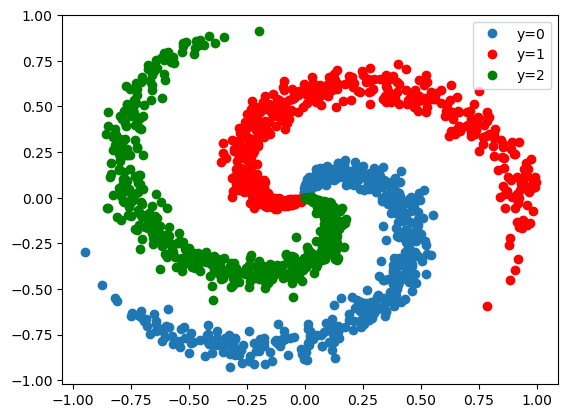

In [17]:
# Create the dataset and plot it
dataset = Data()
dataset.plot_data()
dataset.y = dataset.y.view(-1)

In [18]:
# DataLoader
train_loader = DataLoader(dataset=dataset, batch_size=20)

<a name="4.3"></a>
### <font color='#1f618d'> <b> 4.3. Model, criterion and training function</b> </font>

In [19]:
# Model
class Net(nn.Module):
    """
    A feedforward neural network class that uses linear layers and ReLU activation functions.

    Attributes:
    ----------
    hidden : nn.ModuleList
        A list of linear layers, dynamically created based on the provided layer sizes.

    Methods:
    -------
    forward(activation):
        Defines the forward pass of the network, applying linear transformations 
        followed by ReLU activations (except for the last layer).
    """

    def __init__(self, Layers):
        """
        Initializes the network by dynamically creating linear layers.

        Parameters:
        ----------
        Layers : list
            A list of integers where each element represents the number of neurons 
            in a respective layer of the network.
        """
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()  # List to hold the linear layers
        for input_size, output_size in zip(Layers, Layers[1:]):  # Iterate through layer sizes
            self.hidden.append(nn.Linear(input_size, output_size))  # Create and append linear layers
    
    def forward(self, activation):
        """
        Forward pass of the network.

        Parameters:
        ----------
        activation : torch.Tensor
            The input tensor to the network.

        Returns:
        -------
        torch.Tensor
            The output tensor after passing through all the layers of the network.
        """
        L = len(self.hidden)  # Number of layers
        for (l, linear_transform) in zip(range(L), self.hidden):  # Iterate through layers
            if l < L - 1:  # Apply ReLU activation for all layers except the last
                activation = F.relu(linear_transform(activation))    
            else:  # No activation for the last layer
                activation = linear_transform(activation)
        return activation


In [48]:
# Training function
def train(dataset, model, criterion, train_loader, optimizer, accuracy_fn, epochs=100):
    """
    Train a model on a given dataset using the specified optimizer and criterion.

    Args:
        data_set: The dataset used for evaluating accuracy during training.
        model: The neural network model to be trained.
        criterion: The loss function to optimize.
        train_loader: DataLoader providing batches of training data.
        optimizer: Optimization algorithm used to update model parameters.
        accuracy_fn: Function to calcualte accuracy.
        epochs (int, optional): Number of training epochs. Default is 100.

    Returns:
        dict: A dictionary containing the training loss and accuracy for each epoch:
            {
                "Loss": [loss_epoch_1, loss_epoch_2, ...],
                "Accuracy": [accuracy_epoch_1, accuracy_epoch_2, ...]
            }
    """
    # Initialize lists to store loss and accuracy values for each epoch
    train_loss = []
    train_acc = []
    
    # Loop over the specified number of epochs
    for epoch in range(epochs):
        # Iterate over the batches of data from the DataLoader
        for x, y in train_loader:
            # Zero the gradients from the previous step
            optimizer.zero_grad()
            
            # Perform a forward pass to compute predictions
            yhat = model(x)
            
            # Calculate the loss using the criterion
            loss = criterion(yhat, y)
            
            # Perform backpropagation to compute gradients
            loss.backward()
            
            # Update model parameters using the optimizer
            optimizer.step()
        
        # Append the current epoch's loss to the loss list
        train_loss.append(loss.item())
        
        # Calculate and store the accuracy for the current epoch
        train_acc.append(accuracy_fn(model, dataset))
    
    # Compile the results into a dictionary
    results = {"Loss": train_loss, "Accuracy": train_acc}
    
    # Return the dictionary containing loss and accuracy per epoch
    return results


<a name="4.4"></a>
### <font color='#1f618d'> <b> 4.4. Training </b> </font>

We will try different values for the momentum.

In [59]:
# Define values
Layers = [2, 50, 3]
learning_rate = 0.10
momentum_values = [0, 0.1, 0.2, 0.5]  # List of momentum values to try
epochs = 100
batch_size = 20

# Initialize a dictionary to store loss and accuracy for each momentum
Results = {f"momentum {momentum}": {"Loss": 0, "Accuracy": 0} for momentum in momentum_values}

# Iterate over different momentum values
for momentum in momentum_values:
    # Initialize the model
    model = Net(Layers)
    
    # Define the optimizer with the current momentum value
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    
    # Create the data loader
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size)
    
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()
    
    # Train the model and capture the training results
    results = train(dataset, model, criterion, train_loader, optimizer, 
                                       accuracy, epochs=epochs)

    
    # Update the Results dictionary
    Results[f"momentum {momentum}"]["Model"] = model
    Results[f"momentum {momentum}"]["Loss"] = results['Loss']
    Results[f"momentum {momentum}"]["Accuracy"] = results['Accuracy']
    

    # Training completed
    print(f"Training with momentum {momentum} completed.")



Training with momentum 0 completed.
Training with momentum 0.1 completed.
Training with momentum 0.2 completed.
Training with momentum 0.5 completed.


<a name="4.5"></a>
### <font color='#1f618d'> <b> 4.5. Comparisson of results </b> </font>

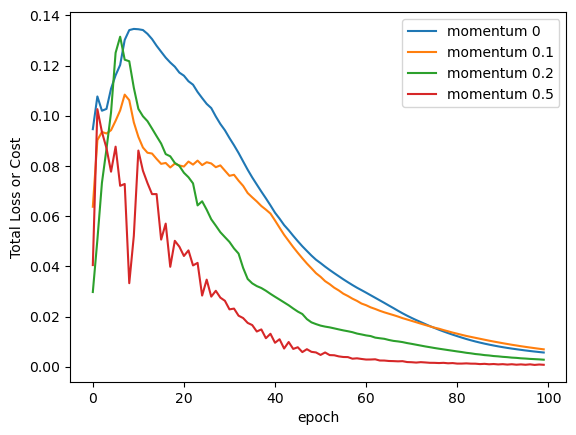

In [94]:
# Plot the Loss result for each term
for key, value in Results.items():
    plt.plot(value['Loss'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

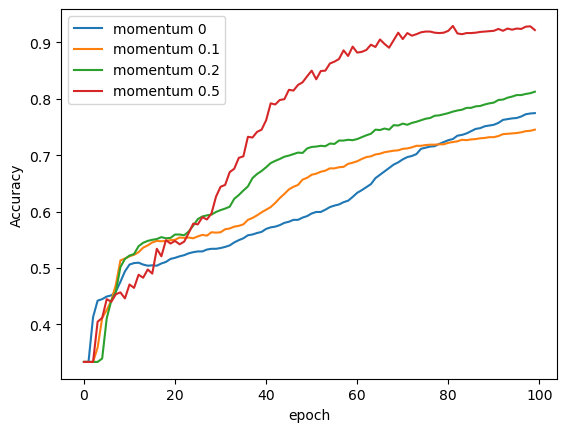

In [95]:
# Plot the Accuracy result for each term
for key, value in Results.items():
    plt.plot(value['Accuracy'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

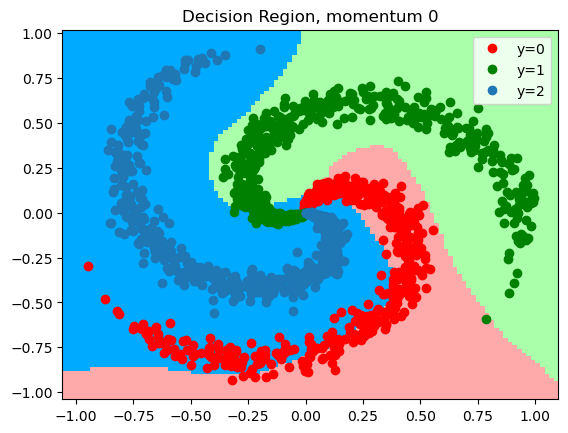

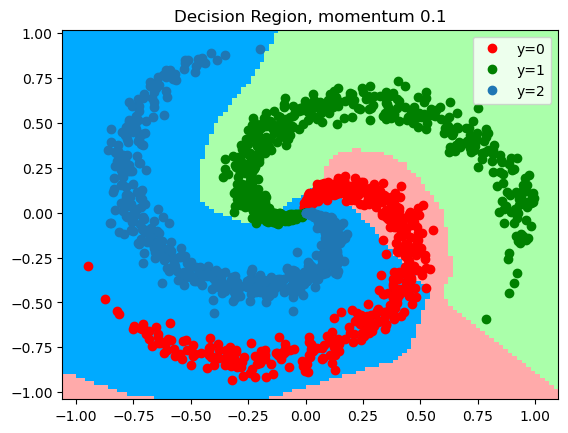

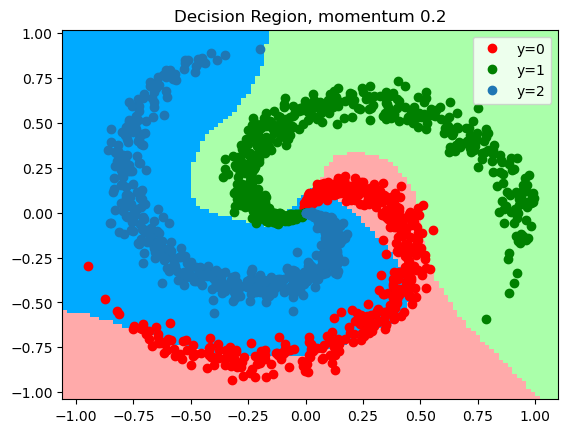

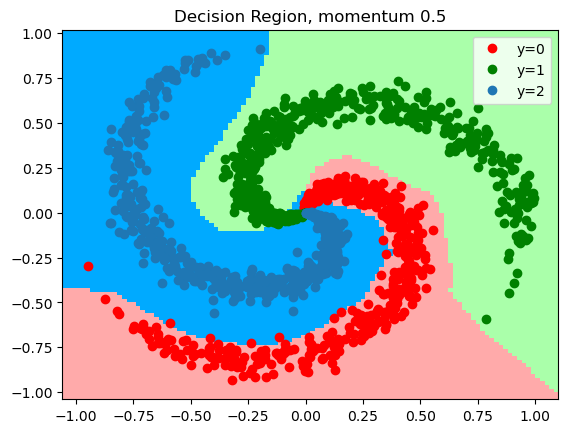

In [92]:
# plot decision regions for each model
for key, value in Results.items():
    plot_decision_regions_3class(value['Model'], dataset, key)

We can see that we get the best results with momentum = 0.5.

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)